In [1]:
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches


with open('data.pkl', 'rb') as f:
   Data = pickle.load(f)
    
bbox_list1 = Data['GT']
u = Data['annotaton']

image_data1 = np.transpose(Data['images'], (0, 3, 1, 2))
images = torch.tensor(image_data1)
images = images.to(dtype=torch.float32)


**Extracting and Refining Regions of Interest (RoIs) from the trained RPN:** The provided code aims to extract Regions of Interest (RoIs) from a pre-trained Region Proposal Network (RPN) using a set of input images and associated anchor boxes. First, anchor boxes are generated based on a predefined grid and anchor shapes. These anchors are then adjusted based on predicted deltas (offsets) from the RPN model to produce RoIs. The code filters these RoIs by applying Intersection over Union (IoU) with a threshold, ensuring only relevant regions are retained. The results are used for further processing, such as detecting lung nodules. The code also includes utility functions for converting between different bounding box formats and calculating IoU, which is essential for evaluating the quality of the RoIs.

In [2]:

def to_VOC_format(width, height, center_x, center_y):
    """
    Convert center coordinate format to min max coordinateformat
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

def to_center_format(xmin_list, ymin_list, xmax_list, ymax_list):
    """
    Convert min max coordinate format to x_center, y_center, height and width format
    """
    height = ymax_list - ymin_list
    width = xmax_list - xmin_list

    center_x = xmin_list + 0.5 * width
    center_y = ymin_list + 0.5 * height

    return width, height, center_x, center_y

def adjust_deltas(anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh):
    """
    Adjust the anchor box with predicted offset
    """
    # ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
    center_x = dx * anchor_width + anchor_center_x

    # ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
    center_y = dy *  anchor_height + anchor_center_y

    # w = np.exp(dw) * anc_width[:, np.newaxis]
    width = np.exp(dw) * anchor_width

    # np.exp(dh) * anc_height[:, np.newaxis]
    height = np.exp(dh) * anchor_height

    return width, height, center_x, center_y

stride = 8
w = h = 800

        # generate all the ordered pair of x and y center
x_center = np.arange(0, w, stride) # [  0,  32,  64,  96, 128, 160, 192,...]
y_center = np.arange(0, h, stride) # [  0,  32,  64,  96, 128, 160, 192,...]


        # to achive this, we will use meshgrid and reshape it
center_list = np.array(np.meshgrid(x_center, y_center,  sparse=False, indexing='xy')).T.reshape(-1,2)
    ##########################################################

anchor_shape = [(8,8),(25,25),(38,38),(58,58),(85,85),(120,120)]
n_anchors = len(center_list) * len(anchor_shape)


anchor_list = np.zeros(shape= (n_anchors, 4))

count = 0
for center in center_list:
         center_x, center_y = center[0], center[1]
            # for each ratio
         for w,h in anchor_shape:
              # for each scale
             anchor_xmin,anchor_ymin,anchor_xmax,anchor_ymax = to_VOC_format(w, h, center_x, center_y)
             #al.append([center_x, center_y, w, h])
                    # append the anchor box to anchor list
             anchor_list[count] = [anchor_xmin, anchor_ymin, anchor_xmax, anchor_ymax]
             count += 1

**Extracting and Refining Regions of Interest (RoIs) from the trained RPN:** The provided code aims to extract Regions of Interest (RoIs) from a pre-trained Region Proposal Network (RPN) using a set of input images and associated anchor boxes. First, anchor boxes are generated based on a predefined grid and anchor shapes. These anchors are then adjusted based on predicted deltas (offsets) from the RPN model to produce RoIs. The code filters these RoIs by applying Intersection over Union (IoU) with a threshold, ensuring only relevant regions are retained. The results are used for further processing, such as detecting lung nodules. The code also includes utility functions for converting between different bounding box formats and calculating IoU, which is essential for evaluating the quality of the RoIs.

In [3]:
def Get_RoI(RPN, image_data, bbox_list1, anchor_list, u, th2):
    # Initialize a list to store predicted RoIs
    predict_roi = []

    # Loop over each image in the batch
    for i in range(image_data.shape[0]):
        img = image_data[i:i+1,:,:,:]
        img = img.to(device)
        
        # Predict anchor deltas and objectness scores
        anchor_deltas, objectiveness_score = model(img)
        anchor_deltas = anchor_deltas.detach().numpy()
        objectiveness_score = objectiveness_score.detach().numpy()
        objectiveness_score = objectiveness_score.reshape(-1, n_anchors)
        anchor_deltas = anchor_deltas.reshape(-1, n_anchors, 4)

        # Extract deltas for adjustment
        dx, dy, dw, dh = anchor_deltas[:, :, 0], anchor_deltas[:, :, 1], anchor_deltas[:, :, 2], anchor_deltas[:, :, 3]

        # Convert anchor box coordinates to center format
        anchor_width, anchor_height, anchor_center_x, anchor_center_y = to_center_format(
            anchor_list[:, 0], anchor_list[:, 1], anchor_list[:, 2], anchor_list[:, 3])

        # Adjust the anchors using the predicted deltas to obtain the final RoIs
        roi_width, roi_height, roi_center_x, roi_center_y = adjust_deltas(
            anchor_width, anchor_height, anchor_center_x, anchor_center_y, dx, dy, dw, dh)

        # Convert RoIs back to VOC format
        roi_min_x, roi_min_y, roi_max_x, roi_max_y = to_VOC_format(roi_width, roi_height, roi_center_x, roi_center_y)
        roi = np.vstack((roi_min_x, roi_min_y, roi_max_x, roi_max_y)).T

        # Filter out small and big RoIs based on size thresholds
        min_size = 30
        max_size = 160
        width = roi[:, 2] - roi[:, 0]
        height = roi[:, 3] - roi[:, 1]
        keep = np.where((width >= min_size) & (height <= max_size) & (height >= min_size))[0]
        roi = roi[keep]
        score = objectiveness_score[:, keep]

        # Sort RoIs by objectiveness score
        sorted_idx = score.flatten().argsort()[::-1]
        roi_sorted = roi[sorted_idx]
        bbox_list = bbox_list1[i]

        # Final filtering based on region content
        imgg = np.reshape(img,(800,800,3))
        img1 = imgg[:,:,1]
        indd = []
        for ii in range(len(roi_sorted)):
            bbox_list11 = roi_sorted[ii]
            anchor_width1, anchor_height1, anchor_center_x1, anchor_center_y1 = to_center_format(
                bbox_list11[0], bbox_list11[1], bbox_list11[2], bbox_list11[3])

            img2 = img1[np.int64(anchor_center_x1-anchor_width1/2):np.int64(anchor_center_x1+anchor_height1/2),
                        np.int64(anchor_center_y1-anchor_width1/2):np.int64(anchor_center_y1+anchor_height1/2)]

            if (img2.shape[0]) > 0:
                indd.append(ii)
                if len(indd) >= th2:
                    break

        roi_sorted = roi_sorted[indd, :]
        predict_roi.append(roi_sorted)
      
    return predict_roi

**Proposal Network (RPN) with PyTorch:** This code defines a custom Region Proposal Network (RPN) using the PyTorch deep learning framework. The CustomRPN class inherits from nn.Module and builds a deep convolutional neural network (CNN) designed for object detection tasks, particularly generating candidate regions for detecting objects within images. The network uses a series of convolutional layers to extract features from the input image and generates bounding box regression outputs and classification scores for each region proposal. The model is then loaded from a pre-trained state and set to evaluation mode, ready to make predictions on new data.

In [4]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CustomRPN class inheriting from nn.Module
class CustomRPN(nn.Module):
    def __init__(self, k=6, weight_decay=0.000001):
        super(CustomRPN, self).__init__()

        # Define the first set of convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Pooling layer for downsampling

        # Define the second set of convolutional layers
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        # Continue adding more convolutional layers for deeper feature extraction
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        # Define additional convolutional layers
        self.conv11 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        
        # Define a transposed convolutional layer for upsampling
        self.deconv1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=1, stride=2, padding=1, output_padding=1)

        # Define final convolutional layers for bounding box regression and classification
        self.conv15 = nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1, padding=1)
        self.conv16 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1)
        self.conv17 = nn.Conv2d(in_channels=512, out_channels=510, kernel_size=1)

        # Regressor for bounding box prediction and classifier for objectness score
        self.regressor = nn.Conv2d(in_channels=512, out_channels=4*k, kernel_size=1)
        self.classifier = nn.Conv2d(in_channels=512, out_channels=k, kernel_size=1)

    # Forward pass through the network
    def forward(self, x):
        x1 = F.relu(self.conv1(x))  # First convolutional block
        x2 = F.relu(self.conv2(x1))
        p1 = self.pool(x2)
        
        x3 = F.relu(self.conv3(p1))  # Second convolutional block
        x4 = F.relu(self.conv4(x3))
        p2 = self.pool(x4)
        
        x5 = F.relu(self.conv5(p2))  # Third convolutional block
        x6 = F.relu(self.conv6(x5))
        x7 = F.relu(self.conv7(x6))
        p3 = self.pool(x7)
        
        x8 = F.relu(self.conv8(p3))  # Fourth convolutional block
        x9 = F.relu(self.conv9(x8))
        x10 = F.relu(self.conv10(x9))
        p4 = self.pool(x10)
        
        x11 = F.relu(self.conv11(p4))  # Fifth convolutional block
        x12 = F.relu(self.conv12(x11))
        x13 = F.relu(self.conv13(x12))
        
        x14 = self.deconv1(x13)  # Upsampling with transposed convolution
        x15 = self.conv15(x14)

        # Additional convolutions for feature maps at different stages
        x18 = self.conv16(p3)
        x19 = self.conv17(x10)
        
        # Concatenate feature maps from different layers
        concatenated = torch.cat([x15, x19, x18], dim=1)
        
        # Predict bounding boxes (regressor) and objectness score (classifier)
        regressor = self.regressor(concatenated)
        classifier = torch.sigmoid(self.classifier(concatenated))

        return regressor, classifier

# Load the entire model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CustomRPN()
# Load the saved model weights
ww = 'RPN_torch'
model = torch.load(ww+".pth", map_location=torch.device('cpu'))
model.eval()  # Set the model to evaluation mode


C:\Users\Amir\AppData\Local\Temp\ipykernel_19340\463199873.py:91: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(ww+".pth", map_location=torch.device('cpu'

CustomRPN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv9): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv11): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv12): Conv2d(512, 512, kernel_siz

**Visualization of Predicted and Ground Truth Bounding Boxes:** The code visualizes the results of the Region Proposal Network (RPN) by plotting both the predicted bounding boxes and the ground truth bounding box on a CT image. The user is prompted to input the number of the CT image, the IoU threshold, and the number of predicted bounding boxes to be displayed. The Get_RoI function is used to extract the Regions of Interest (RoIs) based on the anchor boxes and the predictions from the RPN model. The CT image is then displayed with the ground truth bounding box in green and the predicted bounding boxes in red.

Input the number of CT image: 400
Input the number of predicted bounding box: 10


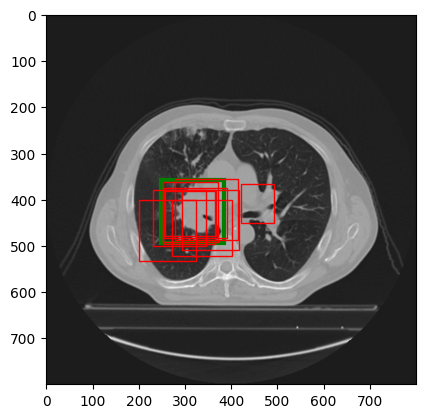

In [6]:
# Prompt the user to input the CT image number, IoU threshold, and number of predicted bounding boxes
num = eval(input('Input the number of CT image:'))
th2 = eval(input('Input the number of predicted bounding box:'))

# Extract the selected CT image and the corresponding ground truth bounding boxes
image_data2 = images[num:num+1,:,:,:]
bbox_list2 = bbox_list1[num:num+1,:]
GT = bbox_list2[0]  # Ground truth bounding box


# Get the Regions of Interest (RoIs) using the pre-trained RPN model
roi = Get_RoI(model, image_data2, bbox_list2, anchor_list, u, 100)

imag = Data['images'][num:num+1,:,:,:]
img = np.reshape(imag, (800, 800, 3))  # Reshape image data for display

# Initialize a plot
fig, ax = plt.subplots()
plt.imshow(img[:,:,1], cmap='gray')  # Display the CT image in grayscale

# Draw the ground truth bounding box in green
rect = patches.Rectangle((GT[1], GT[0]), GT[2]-GT[0], GT[3]-GT[1], linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(rect)

# Draw the predicted bounding boxes in red
for k in range(th2):
    PT = roi[0][k] 
    rect = patches.Rectangle((PT[1], PT[0]), PT[2]-PT[0], PT[3]-PT[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

# Display the plot
plt.show()

**Precision, Recall, and F1-Score Metrics for Test data** The provided code evaluates the performance of a Region Proposal Network (RPN) by calculating precision, recall, and F1-score metrics for predicted bounding boxes against ground truth data. The evaluate function computes these metrics based on the Intersection over Union (IoU) threshold and the number of predicted bounding boxes (th2). The eval_all function iterates through a dataset of CT images, applying the RPN model to extract Regions of Interest (RoIs) and then using the evaluate function to calculate performance metrics for each image. The metrics are averaged across the dataset, producing overall precision, recall, and F1-scores. The code then tests the model's performance across different numbers of predicted bounding boxes and varying IoU thresholds. The results are printed for further analysis, offering insights into the model's effectiveness in detecting relevant regions.

In [ ]:
# Function to evaluate precision, recall, and F1-score for a single ground truth bbox and predicted RoIs
def IOU(box1, box2):
    """
    Compute overlap (IOU) between box1 and box2
    """
    # ------calculate coordinate of overlapping region------
    # take max of x1 and y1 out of both boxes
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])

    # take min of x2 and y2 out of both boxes
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    # check if they atleast overlap a little
    if (x1 < x2 and y1 < y2):
        # ------area of overlapping region------
        width_overlap = (x2 - x1)
        height_overlap = (y2 - y1)
        area_overlap = width_overlap * height_overlap
    else:
        # there is no overlap
        return 0
    # ------computing union------
    # sum of area of both the boxes - area_overlap

    # height and width of both boxes
    width_box1 = (box1[2] - box1[0])
    height_box1 = (box1[3] - box1[1])

    width_box2 = (box2[2] - box2[0])
    height_box2 = (box2[3] - box2[1])
    
    # area of box1 and box2
    area_box1 = width_box1 * height_box1
    area_box2 = width_box2 * height_box2
    # union (including 2 * overlap area (double count))
    area_union_overlap = area_box1 + area_box2
    # union
    area_union = area_union_overlap - area_overlap
    # compute IOU
    iou = area_overlap/ area_union
    return iou
    
def evaluate(bbox_list, roi_sorted, th1, th2):
    tp, fp, fn = 0, 0, 0  # Initialize True Positive, False Positive, False Negative counts
    for k1 in range(th2):
        iou1 = IOU(bbox_list, roi_sorted[k1])  # Calculate IoU between ground truth bbox and predicted RoI
        if (iou1 > th1):
            tp += 1  # Increment TP if IoU exceeds threshold
    if tp == 0:
        fn += 1  # Increment FN if no TP found

    fp = th2 - tp  # Calculate FP as the difference between total predictions and TP
    pre = tp / (tp + fp)  # Calculate precision
    rec = tp / (tp + fn)  # Calculate recall
    if (per + rec) > 0:
        f1_score = (2 * pre * rec) / (pre + rec)  # Calculate F1-score
    else:
        f1_score = 0
    return pre, rec, f1_score

# Function to evaluate precision, recall, and F1-score across multiple images
def eval_all(image_data_train, bbox_list_train, th1, th2):
    roi = Get_RoI(model, image_data_train, bbox_list_train, anchor_list, u, th2)  # Get RoIs from RPN
    precision, recall, f1_score = [], [], []  # Initialize lists to store metrics
    number, _, _, _ = image_data_train.shape  # Get the number of images
    for i in range(number):
        bbox_list = bbox_list_train[i, :]  # Ground truth bbox for current image
        roi_sorted = roi[i]  # Predicted RoIs for current image
        pre, rec , f1= evaluate(bbox_list, roi_sorted, th1, th2)  # Evaluate metrics
        precision.append(pre)  # Store precision
        recall.append(rec)  # Store recall
        f1_score.append(f1)  # Store F1-score

    # Calculate average precision, recall, and F1-score across all images
    precision1 = (sum(precision) / number) * 100
    recall1 = (sum(recall) / number) * 100
    f1_score1 = (sum(f1_score) / number) * 100
    return precision1, recall1, f1_score1

# Testing dataset (subset of the original data)
image_data_test = images[370:, :, :, :]
bbox_list_test = bbox_list1[370:, :]


# Lists to store results for varying number of predicted bounding boxes
pre_all_1, rec_all_1, f1_all_1 = [], [], []

# Lists to store results for varying IoU thresholds
pre_all_2, rec_all_2, f1_all_2 = [], [], []

IoU_th = 0.5  # Constant IoU threshold
Predicted_Box_th = [10, 20, 50, 100, 200, 500]  # Varying number of predicted bounding boxes

# Evaluate metrics by varying number of predicted bounding boxes
for th2 in Predicted_Box_th:
    print(th2)
    precision1, recall1, f1_score1 = eval_all(image_data_test, bbox_list_test, IoU_th, th2)
    pre_all_1.append(precision1)
    rec_all_1.append(recall1)
    f1_all_1.append(f1_score1)

# Print results for analysis
print(pre_all_1)
print(rec_all_1)
print(f1_all_1)


th2 = 100  # Constant number of predicted bounding boxes
IoU_th = [0.5, 0.6, 0.7, 0.8, 0.9, 0.95]  # Varying IoU thresholds

# Evaluate metrics by varying IoU thresholds
for th1 in IoU_th:
    print(th1)
    precision1, recall1, f1_score1 = eval_all(image_data_test, bbox_list_test, th1, th2)
    pre_all_2.append(precision1)
    rec_all_2.append(recall1)
    f1_all_2.append(f1_score1)



print(pre_all_2)
print(rec_all_2)
print(f1_all_2)


**Bar Chart of Precision, Recall, and F1-Score vs. Number of Predicted Bounding Boxes:** This code visualizes the relationship between the number of predicted bounding boxes and the evaluation metrics—Precision, Recall, and F1-Score—using a bar chart. The th2 list represents the different thresholds for the number of predicted bounding boxes, and the pre_all, rec_all, and f1_all arrays contain the corresponding Precision, Recall, and F1-Score values. The bar chart plots these metrics for each threshold, with separate bars for Precision (blue), Recall (green), and F1-Score (red). The chart provides a clear comparison of how each metric varies as the number of predicted bounding boxes changes. The chart also includes labeled axes, a title, and annotated values on top of each bar for better readability.

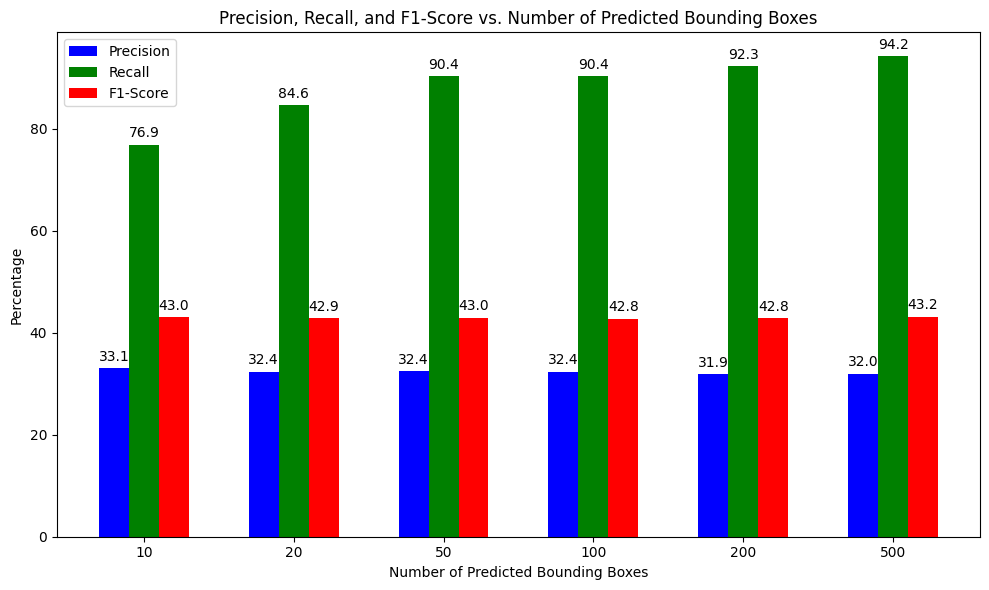

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Data
th2 = Predicted_Box_th # Number of predicted bounding boxes
bounding_boxes = th2
precision = pre_all_1  # Precision values for each threshold
recall = rec_all_1     # Recall values for each threshold
f1_score = f1_all_1    # F1-Score values for each threshold


x = np.arange(len(bounding_boxes))  # the label locations
width = 0.2  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart
rects1 = ax1.bar(x - width, precision, width, label='Precision', color='blue')
rects2 = ax1.bar(x, recall, width, label='Recall', color='green')
rects3 = ax1.bar(x + width, f1_score, width, label='F1-Score', color='red')


# Add some text for labels, title, and custom x-axis tick labels
ax1.set_xlabel('Number of Predicted Bounding Boxes')
ax1.set_ylabel('Percentage')
ax1.set_title('Precision, Recall, and F1-Score vs. Number of Predicted Bounding Boxes')
ax1.set_xticks(x)
ax1.set_xticklabels(bounding_boxes)
ax1.legend()

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.1f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()

plt.show()


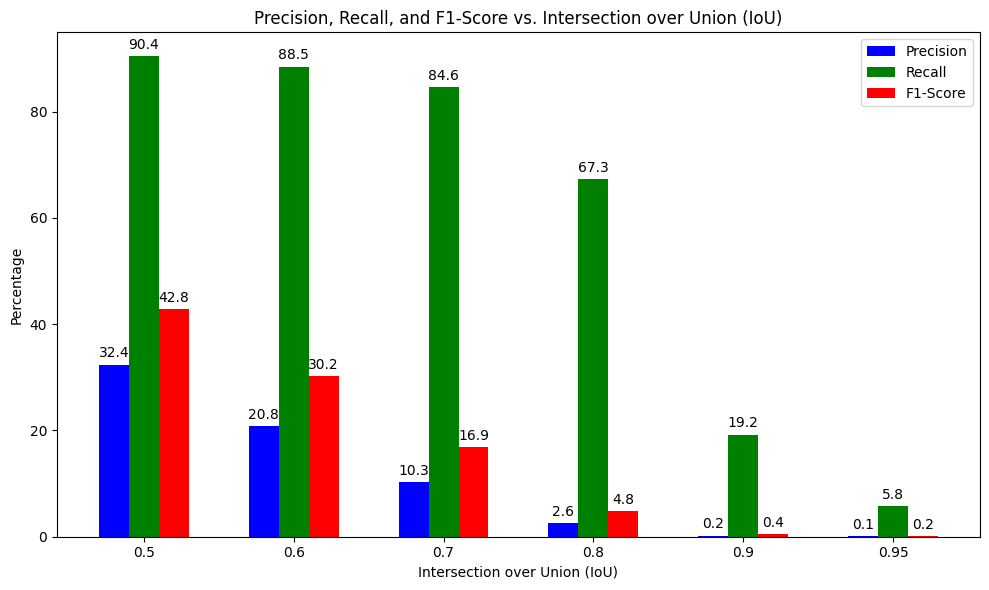

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Data

th1 = IoU_th
IoUs = th1
precision = pre_all_2
recall = rec_all_2
f1_score = f1_all_2

x = np.arange(len(IoUs))  # the label locations
width = 0.2  # the width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar chart
rects1 = ax1.bar(x - width, precision, width, label='Precision', color='blue')
rects2 = ax1.bar(x, recall, width, label='Recall', color='green')
rects3 = ax1.bar(x + width, f1_score, width, label='F1-Score', color='red')


# Add some text for labels, title, and custom x-axis tick labels
ax1.set_xlabel('Intersection over Union (IoU)')
ax1.set_ylabel('Percentage')
ax1.set_title('Precision, Recall, and F1-Score vs. Intersection over Union (IoU)')
ax1.set_xticks(x)
ax1.set_xticklabels(th1)
ax1.legend()

# Add value labels on top of the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax1.annotate(f'{height:.1f}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

add_labels(rects1)
add_labels(rects2)
add_labels(rects3)

fig.tight_layout()

plt.show()
